<a href="https://colab.research.google.com/github/showman-sharma/Semi-bandits/blob/main/linearGeneralization1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

# Creating an adversary

In [ ]:
#L is number of arms; n is number of allowed combinations
# v is n x L
def createActionSet(L,n):
  return np.random.binomial(1,0.5,size = (n,L))

In [ ]:
#L is number of arms
# mus is an L x 1 vector
def pullArms(mus, sig):
  L = mus.shape[0]
  assert sig.shape[0] == L, 'mu sig Shape mismatch'
  return np.array([random.gauss(mus[i],sig[i]) for i in range(L)])

# FPL with Geometric Resampling

In [ ]:
# v is n x L
# mus is L x 1
def FPL_GR(T,v,mus,sig):
  L = mus.shape[0]
  assert v.shape[1] == L, 'Shape of v mismatched mus'
  eta = math.sqrt((math.log(L)+1)/(L*T))
  m = max(np.sum(v,axis = 1))
  M = int((math.sqrt((L*T)/(math.log(L)+1)))/(m*math.e))
  least_loss = np.min(np.dot(v,mus))
  #I_best = np.argmin(np.dot(v,mus))
  Loss = np.zeros(shape = L)
  n = v.shape[0]
  regret = np.zeros(T+1)
  for t in range(T):
    Z = np.random.exponential(eta,size = L)
    I = np.argmin(np.dot(v,Loss-Z))
    K = M*np.ones(L)
    k = 0
    for i in range(M-1):
      Zd = np.random.exponential(eta,size = L)
      In = np.argmin(np.dot(v,Loss-Zd))
      for j in range(L):
        if v[In,j] == 1 and K[j] == M:
          K[j] = i+1
          k += 1
          if k == sum(v[I]):
            break      
    loss = v[I]*pullArms(mus,sig)
    Loss = Loss+ K*loss
    regret[t+1] = regret[t] + (sum(loss)-least_loss)
    del K
  return regret[1:]

In [ ]:
def regrets_FPL_GR(T,v,mus,sig,n = 1000):
  regrets = np.zeros(shape=(n,T))
  for i in range(n):
    regrets[i,:] = np.array(FPL_GR(T,v,mus,sig= sig))
  return regrets

# Kalman Filter

In [ ]:
# Sigma is d x d, Theta is dx1, phi is L x d, phie is d x 1 
def Kalman(Theta,Sigma, sigma, phi, loss):
  L = phi.shape[0]; d = phi.shape[1]
  Theta_new = np.reshape(Theta.copy(),(d,1))
  Sigma_new = Sigma.copy()
  
  for i in range(len(loss)):
    if loss[i]!=0:
      #print(Theta_new.shape,Sigma_new.shape)
      phie = np.reshape((phi[i,:].T).copy(),(d,1))
      C = np.dot(np.dot(phie.T,Sigma_new),phie)+sigma*sigma
      A = (np.dot(Sigma_new,phie)/C).reshape(d,1)
      B =np.dot(A,phie.T)
      #print(A.shape)
      change1 = np.dot(B,Theta_new)
      Theta_new = Theta_new - change1 + np.reshape(loss[i]*A,(d,1))
      Sigma_new = Sigma_new - np.dot(np.dot(A,phie.T),Sigma_new)
  return Theta_new, Sigma_new 

# CombLin TS

In [ ]:
def CLTS(T,v, mus, phi, stddev, lam = 1, sig = 1): #stddev is for arms and sig is for algorithm
  L = v.shape[1]; #Number of arms
  n = v.shape[0]  #number of allowed combinations
  d = phi.shape[1]
  assert phi.shape[0] == L, 'Phi and v dim mismatch'
  #mus = np.dot(Phi,Theta_act)
  Sigma = lam*lam*np.eye(d)
  Theta = np.zeros((d,1))
  regret = np.zeros(T+1)
  least_loss = np.min(np.dot(v,mus))

  for t in range(T):

    Theta_t = np.random.multivariate_normal(np.reshape(Theta,d),Sigma)
    P = np.dot(phi,Theta_t)
    I = np.argmin(np.dot(v,P))
    loss = v[I]*pullArms(mus,stddev)
    #print(loss.shape)
    regret[t+1] = regret[t] + (sum(loss)-least_loss)
    Theta, Sigma = Kalman(Theta,Sigma,sig,phi,loss)
  return regret[1:]  

In [ ]:
def regrets_CLTS(T, mus,stddev, phi ,v, n = 1000, lam = 1, sig = 1):
  regrets = np.zeros(shape=(n,T))
  for i in range(n):
    regrets[i,:] = np.array(CLTS(T,v, mus, phi, stddev , lam , sig ))
  return regrets

# CombLin UCB

In [ ]:
def CLUCB(T,v,mus, phi, stddev, lam = 1, sig = 1, dell = -1):
  m = max(np.sum(v,axis = 1))
  L = v.shape[1]; #Number of arms
  n = v.shape[0]  #number of allowed combinations
  d = phi.shape[1]
  dell = (1/(n*m)) if dell == -1 else dell
  assert phi.shape[0] == L, 'Phi and v dim mismatch'
  c = math.sqrt(d*math.log(1+n*m*lam*lam/(d*sig*sig))-2*math.log(dell)) + d/lam
  least_loss = np.min(np.dot(v,mus))
  Sigma = lam*lam*np.eye(d)
  Theta = np.zeros((d,1))
  regret = np.zeros(T+1)
  P = np.zeros((L,1))

  for t in range(T):
    #for i in range(L):
      #phie = phi[i,:].T
      #P[i,0] =   np.inner(phie,Theta.T) - c*math.sqrt(np.dot(np.dot(phie.T,Sigma),phie))
    A = np.dot(phi,Sigma)
    B = A*A
    P = np.dot(phi,Theta)- np.reshape(c*np.sum(B,axis=1),(L,1))
    I = np.argmin(np.dot(v,P))
    loss = v[I]*pullArms(mus,stddev)
    regret[t+1] = regret[t] + (sum(loss)-least_loss)
    Theta, Sigma = Kalman(Theta,Sigma,sig,phi,loss)
  return regret[1:]  

In [ ]:
def regrets_CLUCB(T, mus,stddev ,phi,v, n = 1000, lam = 1, sig = 1,dell = -1):
  regrets = np.zeros(shape=(n,T))
  for i in range(n):
    regrets[i,:] = np.array(CLUCB(T,v,mus, phi, stddev, lam, sig, dell))
  return regrets

# Coherent Learning Case

## Adversary 1:
T = 1000, 
L = 100, 
n = 30, 
d = 10

In [ ]:
T = 1000
L = 100
n = 30
d = 10
v = createActionSet(L,n)
Phi = np.random.normal(0,5,size = (L,d))
Theta = np.random.rand(d,1)
mus = np.reshape(np.dot(Phi,Theta),L)
sig = np.ones(L)

In [ ]:
reg_FPL_GR = regrets_FPL_GR(T,v,mus,sig,n=20)

In [ ]:
regret_exp_FPL_GR = np.mean(reg_FPL_GR,axis = 0)
regret_std_FPL_GR = np.std(reg_FPL_GR,axis = 0)

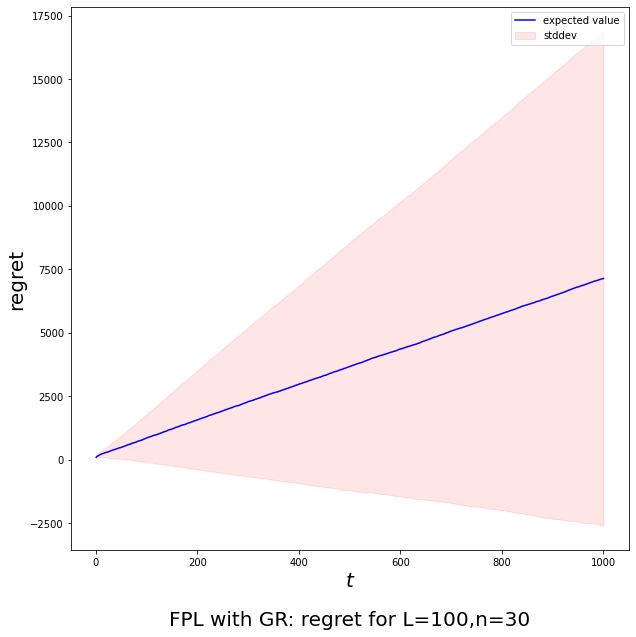

In [ ]:
plt.figure(0,figsize = (10,10));
plt.plot([i+1 for i in range(T)],regret_exp_FPL_GR,label = 'expected value',color = 'b');
plt.fill_between([i+1 for i in range(T)],regret_exp_FPL_GR-regret_std_FPL_GR,regret_exp_FPL_GR+regret_std_FPL_GR,color = 'r', label = 'stddev',alpha = 0.1)
plt.xlabel('$t$',fontsize = 20);
plt.ylabel('regret',fontsize = 20);
plt.title('FPL with GR: regret for L=100,n=30',fontsize = 20,y=-0.15);
plt.legend();

In [ ]:
reg_CLTS = regrets_CLTS(T,mus,sig,Phi,v,n=20)

In [ ]:
regret_exp_CLTS = np.mean(reg_CLTS,axis = 0)
regret_std_CLTS= np.std(reg_CLTS,axis = 0)

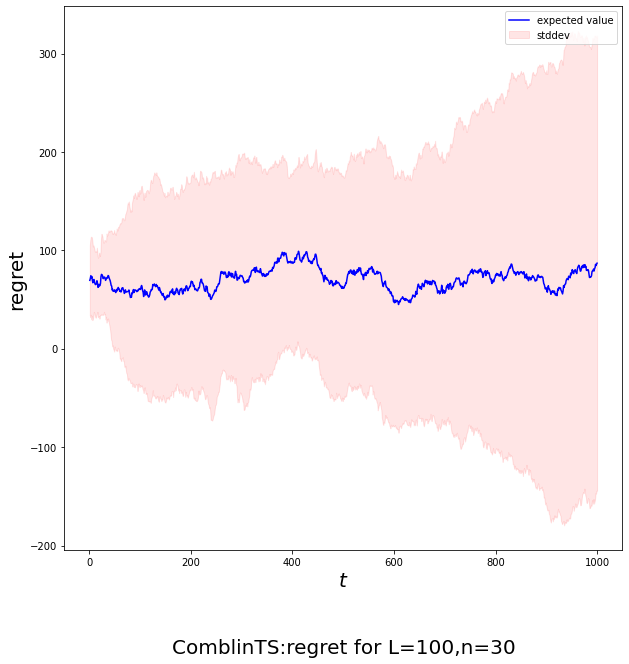

In [ ]:
plt.figure(1,figsize = (10,10));
plt.plot([i+1 for i in range(T)],regret_exp_CLTS,label = 'expected value',color = 'b');
plt.fill_between([i+1 for i in range(T)],regret_exp_CLTS-regret_std_CLTS,regret_exp_CLTS+regret_std_CLTS,color = 'r', label = 'stddev',alpha = 0.1)
plt.xlabel('$t$',fontsize = 20);
plt.ylabel('regret',fontsize = 20);
plt.title('ComblinTS:regret for L=100,n=30',fontsize = 20,y=-0.2);
plt.legend();

In [ ]:
reg_CLUCB = regrets_CLUCB(T,mus,sig,Phi,v,n=20)

In [ ]:
regret_exp_CLUCB = np.mean(reg_CLUCB,axis = 0)
regret_std_CLUCB= np.std(reg_CLUCB,axis = 0)

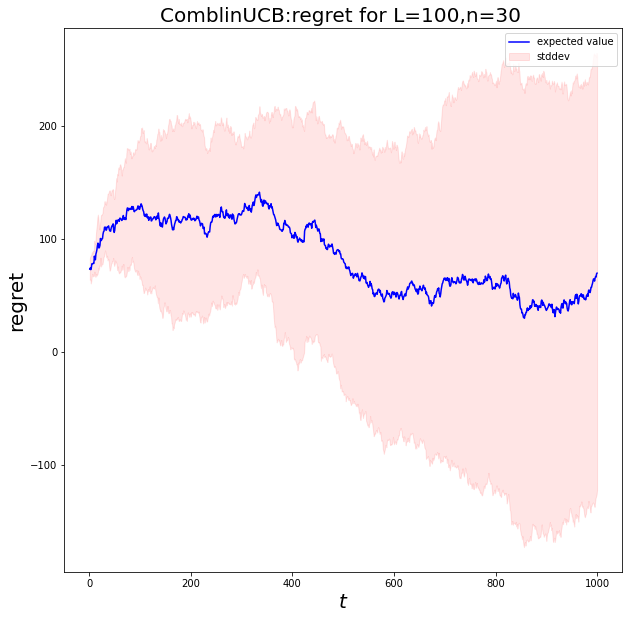

In [ ]:
plt.figure(2,figsize = (10,10));
plt.plot([i+1 for i in range(T)],regret_exp_CLUCB,label = 'expected value',color = 'b');
plt.fill_between([i+1 for i in range(T)],regret_exp_CLUCB-regret_std_CLUCB,regret_exp_CLUCB+regret_std_CLUCB,color = 'r', label = 'stddev',alpha = 0.1)
plt.xlabel('$t$',fontsize = 20);
plt.ylabel('regret',fontsize = 20);
plt.title('ComblinUCB:regret for L=100,n=30 ',fontsize = 20);
plt.legend();

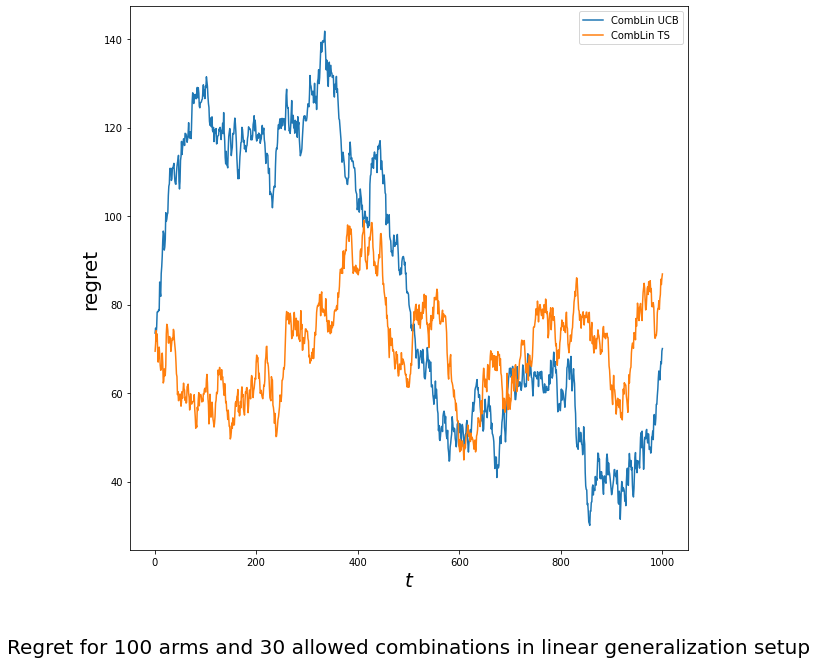

In [ ]:
plt.figure(3,figsize = (10,10));
plt.plot([i+1 for i in range(T)],regret_exp_CLUCB,label = 'CombLin UCB');
plt.plot([i+1 for i in range(T)],regret_exp_CLTS,label = 'CombLin TS');
#plt.plot([i+1 for i in range(T)],regret_exp_FPL_GR,label = 'FPL with GR');
plt.xlabel('$t$',fontsize = 20);
plt.ylabel('regret',fontsize = 20);
plt.title('Regret for 100 arms and 30 allowed combinations in linear generalization setup',fontsize = 20,y=-0.2);
plt.legend();

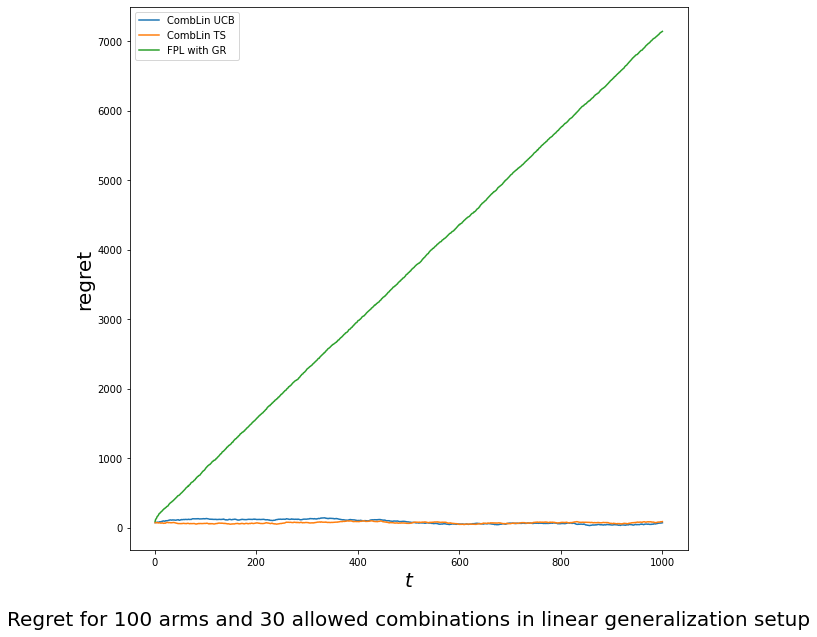

In [ ]:
plt.figure(3,figsize = (10,10));
plt.plot([i+1 for i in range(T)],regret_exp_CLUCB,label = 'CombLin UCB');
plt.plot([i+1 for i in range(T)],regret_exp_CLTS,label = 'CombLin TS');
plt.plot([i+1 for i in range(T)],regret_exp_FPL_GR,label = 'FPL with GR');
plt.xlabel('$t$',fontsize = 20);
plt.ylabel('regret',fontsize = 20);
plt.title('Regret for 100 arms and 30 allowed combinations in linear generalization setup',fontsize = 20,y=-0.15);
plt.legend();